# FINAL PROJECT CIS 432
## Members: Miguel Novo Villar, Lisa Pink, Dikshant Tiwari, Thomas Durkin & Maheen Ansari
## 28 April 2022

## Import Modules

In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle


from sklearn.model_selection import train_test_split
from sklearn.impute import MissingIndicator
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn import tree, linear_model, neighbors
from sklearn.ensemble import AdaBoostClassifier  
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

import random
random.seed(10)

# ETL
<a class='anchor' id='etl'></a>

In [66]:
df = pd.read_csv("heloc_dataset_v1.csv")
cols = df.columns

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10459 entries, 0 to 10458
Data columns (total 24 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   RiskPerformance                     10459 non-null  object
 1   ExternalRiskEstimate                10459 non-null  int64 
 2   MSinceOldestTradeOpen               10459 non-null  int64 
 3   MSinceMostRecentTradeOpen           10459 non-null  int64 
 4   AverageMInFile                      10459 non-null  int64 
 5   NumSatisfactoryTrades               10459 non-null  int64 
 6   NumTrades60Ever2DerogPubRec         10459 non-null  int64 
 7   NumTrades90Ever2DerogPubRec         10459 non-null  int64 
 8   PercentTradesNeverDelq              10459 non-null  int64 
 9   MSinceMostRecentDelq                10459 non-null  int64 
 10  MaxDelq2PublicRecLast12M            10459 non-null  int64 
 11  MaxDelqEver                         10459 non-null  in

array([[<AxesSubplot:title={'center':'ExternalRiskEstimate'}>,
        <AxesSubplot:title={'center':'MSinceOldestTradeOpen'}>,
        <AxesSubplot:title={'center':'MSinceMostRecentTradeOpen'}>,
        <AxesSubplot:title={'center':'AverageMInFile'}>,
        <AxesSubplot:title={'center':'NumSatisfactoryTrades'}>],
       [<AxesSubplot:title={'center':'NumTrades60Ever2DerogPubRec'}>,
        <AxesSubplot:title={'center':'NumTrades90Ever2DerogPubRec'}>,
        <AxesSubplot:title={'center':'PercentTradesNeverDelq'}>,
        <AxesSubplot:title={'center':'MSinceMostRecentDelq'}>,
        <AxesSubplot:title={'center':'MaxDelq2PublicRecLast12M'}>],
       [<AxesSubplot:title={'center':'MaxDelqEver'}>,
        <AxesSubplot:title={'center':'NumTotalTrades'}>,
        <AxesSubplot:title={'center':'NumTradesOpeninLast12M'}>,
        <AxesSubplot:title={'center':'PercentInstallTrades'}>,
        <AxesSubplot:title={'center':'MSinceMostRecentInqexcl7days'}>],
       [<AxesSubplot:title={'center'

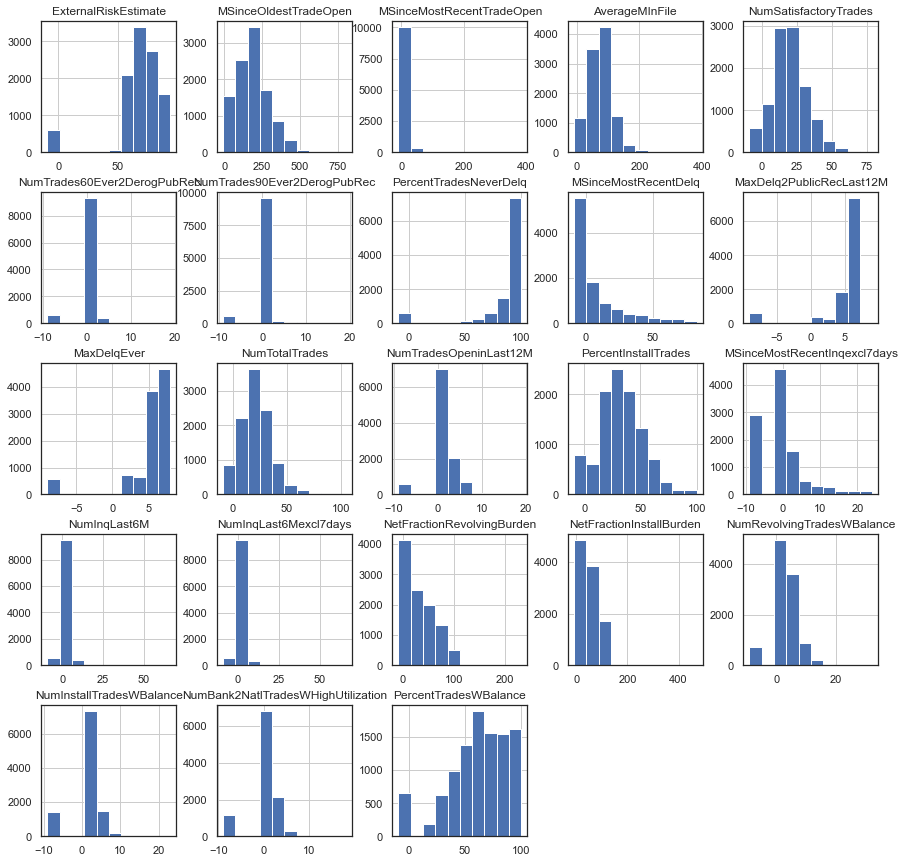

In [68]:
df.hist(figsize=(15,15))

## DATA PREPROCESSING AND FEATURE ENGINEERING

In [69]:
#remove -9 from dataframe and convert -7 and -8 into the mean
df.drop(df.index[df["ExternalRiskEstimate"] == -9], inplace = True)

#['Good', 'Bad'] = [0, 1]
df['RiskPerformance'] = df['RiskPerformance'].replace(["Good",'Bad'],[0,1])

In [70]:
#IMPUTER

#turn -7,-8 into nan for easy manipulation
df = (df.replace([-7, -8], np.nan))

#df impute
imputer_test = SimpleImputer(strategy="mean", missing_values=np.nan)
imputer_test.fit(df)

# # #Output
df1 = imputer_test.transform(df)
df_trans = pd.DataFrame(data = df1, columns=cols)

# Descriptive Analysis
<a class='anchor' id='descriptive-analysis'></a>

## Descriptive Statistics
<a class='anchor' id='descriptive-statistics'></a>

array([[<AxesSubplot:title={'center':'RiskPerformance'}>,
        <AxesSubplot:title={'center':'ExternalRiskEstimate'}>,
        <AxesSubplot:title={'center':'MSinceOldestTradeOpen'}>,
        <AxesSubplot:title={'center':'MSinceMostRecentTradeOpen'}>,
        <AxesSubplot:title={'center':'AverageMInFile'}>],
       [<AxesSubplot:title={'center':'NumSatisfactoryTrades'}>,
        <AxesSubplot:title={'center':'NumTrades60Ever2DerogPubRec'}>,
        <AxesSubplot:title={'center':'NumTrades90Ever2DerogPubRec'}>,
        <AxesSubplot:title={'center':'PercentTradesNeverDelq'}>,
        <AxesSubplot:title={'center':'MSinceMostRecentDelq'}>],
       [<AxesSubplot:title={'center':'MaxDelq2PublicRecLast12M'}>,
        <AxesSubplot:title={'center':'MaxDelqEver'}>,
        <AxesSubplot:title={'center':'NumTotalTrades'}>,
        <AxesSubplot:title={'center':'NumTradesOpeninLast12M'}>,
        <AxesSubplot:title={'center':'PercentInstallTrades'}>],
       [<AxesSubplot:title={'center':'MSinceMostR

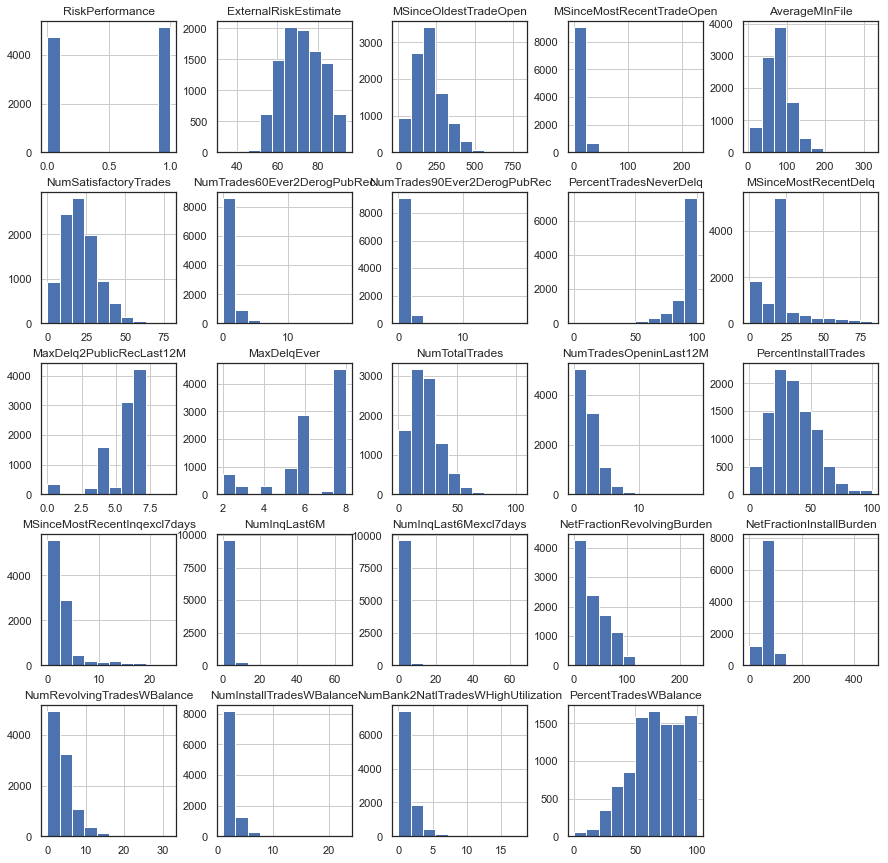

In [71]:
df_trans.hist(figsize=(15,15))

In [72]:
df_trans.describe()

,RiskPerformance,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,...,PercentInstallTrades,MSinceMostRecentInqexcl7days,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance
count,9861.000000,9861.000000,9861.000000,9861.000000,9861.000000,9861.000000,9861.000000,9861.000000,9861.00000,9861.000000,...,9861.000000,9861.000000,9861.000000,9861.000000,9861.000000,9861.000000,9861.000000,9861.000000,9861.000000,9861.000000
mean,0.520028,72.060440,200.827271,9.520535,78.744245,21.130413,0.580570,0.383734,92.35899,21.888602,...,34.593348,2.479687,1.455532,1.396714,34.862219,68.528609,4.101936,2.485067,1.092084,66.454822
std,0.499624,9.871795,96.721030,12.288235,33.904646,11.302849,1.238056,0.991851,11.76934,14.860165,...,17.907026,4.162129,2.135229,2.095491,28.636117,20.139758,2.998801,1.562158,1.490615,22.023025
min,0.000000,33.000000,2.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,0.000000,64.000000,137.000000,3.000000,57.000000,13.000000,0.000000,0.000000,89.00000,14.000000,...,21.000000,0.000000,0.000000,0.000000,9.000000,65.000000,2.000000,1.000000,0.000000,50.000000
50%,1.000000,72.000000,188.000000,6.000000,76.000000,20.000000,0.000000,0.000000,97.00000,21.888602,...,33.000000,1.000000,1.000000,1.000000,30.000000,68.528609,3.000000,2.000000,1.000000,67.000000
75%,1.000000,80.000000,255.000000,12.000000,97.000000,28.000000,1.000000,0.000000,100.00000,21.888602,...,45.000000,2.479687,2.000000,2.000000,56.000000,80.000000,5.000000,3.000000,1.092084,83.000000
max,1.000000,94.000000,803.000000,227.000000,322.000000,79.000000,19.000000,19.000000,100.00000,83.000000,...,100.000000,24.000000,66.000000,66.000000,232.000000,471.000000,32.000000,23.000000,18.000000,100.000000


Correlation Matrix
<a class='anchor' id='corr-matrix'></a>

Text(0.5, 1.0, 'Correlation Matrix')

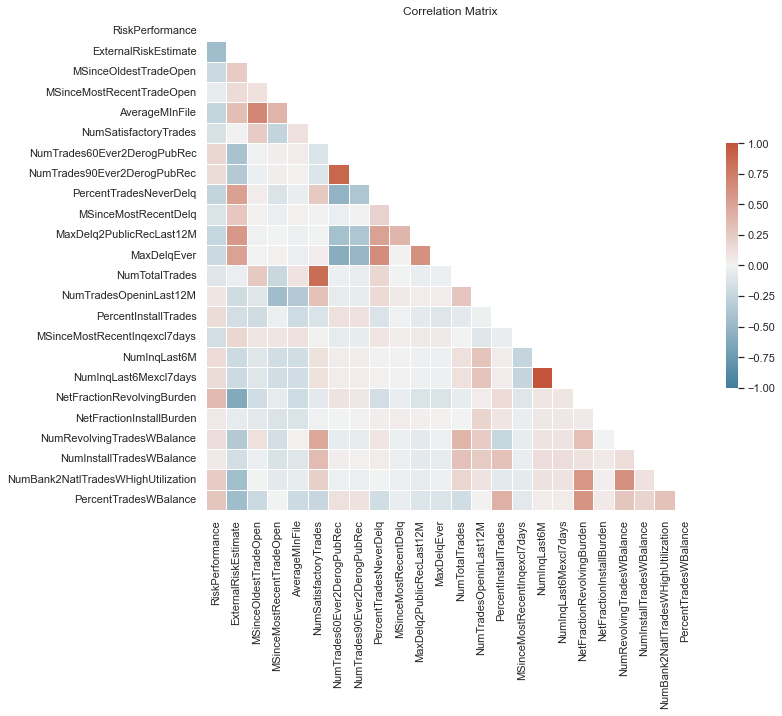

In [73]:
sns.set_theme(style="white")

# Compute the correlation matrix
corr = df_trans.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.set_title('Correlation Matrix')

In [74]:
#separate variables
X = df_trans.iloc[:,1:24]
Y = df_trans.iloc[:,[0]]

## MODELS

In [75]:
#Split dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

X_train_t_tr, X_train_t_val, Y_train_t_tr, Y_train_t_val = train_test_split(X_train, Y_train, test_size=0.3)

Tree, Linear_model, K-Neighbors    

In [105]:
clf_tree    = tree.DecisionTreeClassifier().fit(X_train_t_tr, Y_train_t_tr.values.ravel())
clf_log_reg = linear_model.LogisticRegression(max_iter=10000).fit(X_train_t_tr, Y_train_t_tr.values.ravel()) 
clf_knn     = neighbors.KNeighborsClassifier().fit(X_train_t_tr, Y_train_t_tr.values.ravel())
clf_grad = GradientBoostingClassifier(n_estimators=10000, learning_rate=1.0,max_depth=1).fit(X_train_t_tr, Y_train_t_tr.values.ravel()) 

In [113]:
%%timeit
clf_grad = GradientBoostingClassifier(n_estimators=1000, learning_rate=1.0,max_depth=1).fit(X_train_t_tr, Y_train_t_tr.values.ravel()) 

2.74 s ± 153 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [106]:
print('Decision tree accuracy: %.3f'%accuracy_score(Y_train_t_val, clf_tree.predict(X_train_t_val)))
print('Logistic regression accuracy: %.3f'%accuracy_score(Y_train_t_val, clf_log_reg.predict(X_train_t_val)))
print('KNN accuracy: %.3f'%accuracy_score(Y_train_t_val, clf_knn.predict(X_train_t_val)))
print('GradientBoosting accuracy: %.3f'%accuracy_score(Y_train_t_val, clf_grad.predict(X_train_t_val)))

Decision tree accuracy: 0.610
Logistic regression accuracy: 0.725
KNN accuracy: 0.666
GradientBoosting accuracy: 0.718


Cross Validation - Tree, Linear_model, K-Neighbors

In [107]:
cv_results_tree = cross_validate(tree.DecisionTreeClassifier(), X_train, Y_train.values.ravel(), cv=5, return_estimator=True)
cv_results_log_reg = cross_validate(linear_model.LogisticRegression(max_iter=10000), X_train, Y_train.values.ravel(), cv=5, return_estimator=True)
cv_results_knn = cross_validate(neighbors.KNeighborsClassifier(), X_train, Y_train.values.ravel(), cv=5, return_estimator=True)
cv_results_GradBoos = cross_validate(GradientBoostingClassifier(), X_train, Y_train.values.ravel(), cv=5, return_estimator=True)

In [108]:
print('Classification tree - CV accuracy score %.3f'%cv_results_tree['test_score'].mean()) 
print('Logistic regresion - CV accuracy score %.3f'%cv_results_log_reg['test_score'].mean())
print('KNN - CV accuracy score %.3f'%cv_results_knn['test_score'].mean()) 
print('GradBoos - CV accuracy score %.3f'%cv_results_GradBoos['test_score'].mean())

Classification tree - CV accuracy score 0.633
Logistic regresion - CV accuracy score 0.728
KNN - CV accuracy score 0.670
GradBoos - CV accuracy score 0.725


Validation Accuracy - Tree, Linear_model, K-Neighbors

In [109]:
print('Classification tree - validation accuracy score: %.3f'%accuracy_score(Y_train_t_val, clf_tree.predict(X_train_t_val)))
print('Logistic regresion - validation accuracy score: %.3f'%accuracy_score(Y_train_t_val, clf_log_reg.predict(X_train_t_val)))
print('KNN - validation accuracy score: %.3f'%accuracy_score(Y_train_t_val, clf_knn.predict(X_train_t_val)))
print('GradBoos - validation accuracy score: %.3f'%accuracy_score(Y_train_t_val, clf_grad.predict(X_train_t_val)))

Classification tree - validation accuracy score: 0.610
Logistic regresion - validation accuracy score: 0.725
KNN - validation accuracy score: 0.666
GradBoos - validation accuracy score: 0.718


Perform grid search - Logistic Regression

In [ ]:
param_grid = [    
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : np.logspace(-4, 4, 20)
    }
]
clf = GridSearchCV(linear_model.LogisticRegression(), param_grid = param_grid, cv = 5, n_jobs=-1, scoring = "accuracy")
clf.fit(X_train_t_tr, Y_train_t_tr)

In [82]:
clf.best_params_

{'C': 29.763514416313132, 'penalty': 'l2'}

In [83]:
#Use best params - logistic Regression
clf_log_reg = linear_model.LogisticRegression(max_iter=10000, penalty="l2").fit(X_train_t_tr, Y_train_t_tr.values.ravel()) 
print('Logistic regression accuracy: %.3f'%accuracy_score(Y_train_t_val, clf_log_reg.predict(X_train_t_val)))

Logistic regression accuracy: 0.725


Feature Importance

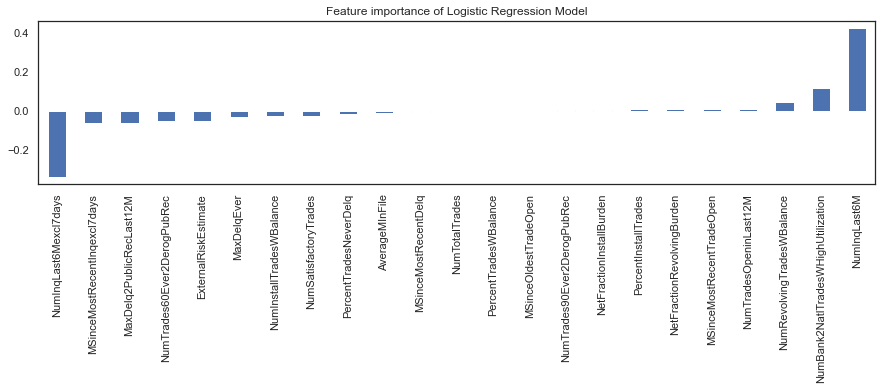

In [87]:
pd.Series(data=clf_log_reg.coef_[0], 
          index=cols[1:24]).sort_values().plot.bar(figsize=(15,3), 
                                                     title='Feature importance of Logistic Regression Model');                                                     

Gradient Boosting

In [110]:
#Perfom model
clf_grad = GradientBoostingClassifier(n_estimators=1000, learning_rate=1.0,
    max_depth=1).fit(X_train_t_tr, Y_train_t_tr.values.ravel()) 
clf_grad.score(X_train_t_tr, Y_train_t_tr.values.ravel())

0.7542951769819913

In [89]:
#Grid Search Gradient Boosting
parameters = {
    "learning_rate": [0.01, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 1),
    "min_samples_leaf": np.linspace(0.1, 0.5, 1),
    "max_depth":[3,5,8],
    "max_features":["sqrt"],
    "criterion": ["friedman_mse"],
    "subsample":[0.5, 0.8,1.0]
    }
#passing the scoring function in the GridSearchCV
clf_grad_boos = GridSearchCV(GradientBoostingClassifier(), parameters,scoring="accuracy",refit=False,cv=3, n_jobs=-1)

clf_grad_boos.fit(X_train_t_tr, Y_train_t_tr)

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'criterion': ['friedman_mse'],
                         'learning_rate': [0.01, 0.1, 0.15, 0.2],
                         'max_depth': [3, 5, 8], 'max_features': ['sqrt'],
                         'min_samples_leaf': array([0.1]),
                         'min_samples_split': array([0.1]),
                         'subsample': [0.5, 0.8, 1.0]},
             refit=False, scoring='accuracy')

In [90]:
clf_grad_boos.best_params_

{'criterion': 'friedman_mse',
 'learning_rate': 0.1,
 'max_depth': 8,
 'max_features': 'sqrt',
 'min_samples_leaf': 0.1,
 'min_samples_split': 0.1,
 'subsample': 0.5}

In [91]:
scores1 = cross_val_score(clf_grad, X_train_t_tr, Y_train_t_tr.values.ravel(), cv=5)
print("%0.2f Gradient boosting accuracy with a standard deviation of %0.2f" % (scores1.mean(), scores1.std()))

0.73 Gradient boosting accuracy with a standard deviation of 0.01


In [92]:
print('Gradient Boosting- validation accuracy score: %.3f'%accuracy_score(Y_train_t_val, clf_grad.predict(X_train_t_val)))

Gradient Boosting- validation accuracy score: 0.718


In [93]:
with open('logistic_regression_model.p', 'wb') as f:
	pickle.dump(clf_log_reg, f)